#  MUSE Continuum Source Extraction (MCSE)

Extract continuum source from MUSE IFU data and generate a continuum catalog. main idea to extract the continuum source is that generate a psudo bw image and use sextractor to extract the source.

In [1]:
#import necessary package

#append my script dictionary to the searching path of python
import sys
sys.path.append('/Users/shiwuzhang/W&S/ASTRO/script')
print(sys.path)
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import photutils
import imp
from cube import CubeData
from imag import ImgInterSmo
from astropy.io import fits
from astropy import visualization
from astropy import stats
from scipy import signal

['', '/Users/shiwuzhang/W&S/ASTRO/script/additional script', '/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python37.zip', '/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7', '/usr/local/Cellar/python/3.7.0/Frameworks/Python.framework/Versions/3.7/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/site-packages/IPython/extensions', '/Users/shiwuzhang/.ipython', '/Users/shiwuzhang/W&S/ASTRO/script']


I first read the cube and sum each slice up to generate the psudo broad band image

In [3]:
cube,wavelength,wcs,cube_object=CubeData.ReadCube(path='/Users/shiwuzhang/W&S/ASTRO/MUSE/data',
                       cube_name='extra-galactic-field1.fits',hdu=1,wcs_mark=False)

SpectralCube with shape=(3801, 323, 321) and unit=1e-20 erg / (Angstrom cm2 s):
 n_x:    321  type_x: RA---TAN  unit_x: deg    range:   353.684386 deg:  353.702393 deg
 n_y:    323  type_y: DEC--TAN  unit_y: deg    range:    -9.145538 deg:   -9.127649 deg
 n_s:   3801  type_s: AWAV      unit_s: Angstrom  range:     4599.602 Angstrom:    9349.602 Angstrom


'10**(-20)*erg/s/cm**2/Angstrom' contains multiple slashes, which is discouraged by the FITS standard
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


When I check the psudo broad band image, I found that the background of psudo bw image is very large, then I estimate background and subtract it from each slice

In [4]:
def Plotfitsimg(img,ax):
    
    norm=visualization.ImageNormalize(img,interval=visualization.ZScaleInterval(),
                                         stretch=visualization.LinearStretch())
    ax.imshow(img,norm=norm)
    return fig,ax

def Bkgestimate(img,bkposition,bkradius):
    aperture=photutils.CircularAperture(bkposition,r=bkradius)
    photo_catalog=photutils.aperture_photometry(img,aperture)
    aperture=np.pi*(bkradius**2)
    bkg=photo_catalog['aperture_sum']/aperture
    return bkg

def Bkgsubtract(cube,bkposition,bkradius):
    cube_shape=np.shape(cube)
    goodcube=np.zeros(cube_shape)
    for i in range(cube_shape[0]):
        bkg=Bkgestimate(cube[i,:,:],bkposition,bkradius)
        goodcube[i,:,:]=cube[i,:,:]-bkg
    return goodcube

def Rmbadpixel(cube,badthresh,fillvalue=0):
    
    index=np.where(cube<badthresh)
    goodcube=cube.copy()
    goodcube[index]=fillvalue
    return goodcube

def Rmbadslice(cube,bkposition,bkradius,badthresh):
    
    cube_shape=np.shape(cube)
    goodcube=cube.copy()
    k=0
    for i in range(cube_shape[0]):
        bk=Bkgestimate(goodcube[i,:,:],bkposition,bkradius)
        if bk>=badthresh:
            goodcube[i,:,:]=0
            k+=1
    print(k)
    return goodcube

def Bkggenerate(img,mean,sigma):
    
    img_shpae=np.shape(img)
    bkg1=np.random.normal(mean,sigma,img_shpae)
    bkg2=np.random.normal(0,sigma/10,img_shpae)
    bkg1[np.where(img!=0)]=0.
    bkg2[np.where(img==0)]=0.
    bkg=bkg1+bkg2
    return bkg
    
def Imgcrop(img,crop_index,fillvalue):
    
    goodimg=img.copy()
    goodimg[:crop_index,:]=fillvalue
    goodimg[:,:crop_index]=fillvalue
    goodimg[-crop_index:,:]=fillvalue
    goodimg[:,-crop_index:]=fillvalue
    return goodimg

def Imgmaskobj(img,sigma,cenfunc):
    img_new=img.copy()
    img_new[np.where(np.isnan(img_new))]=0.
    img_obj=stats.sigma_clip(img,sigma=sigma,cenfunc=cenfunc)
    img_obj.data[np.where(img_obj.mask)]=0.
#     print(type(img_obj.data))
    return img_obj.data   

def Cubemaskobj(cube,sigma,cenfunc):
    cube_shape=np.shape(cube)
    cube_new=np.zeros(cube_shape)
    for i in range(cube_shape[0]):
        cube_new[i,:,:]=Imgmaskobj(cube[i,:,:],sigma,cenfunc)
    return cube_new

#estimate and subtract background from each slice

In [419]:
patterncube=CubeData.CubeNoiseFilter(cube,5,.2,'hp')
cube_new=cube.copy()-patterncube

In [423]:
img=np.sum(cube_new[1000:-1000],axis=0)
# maskimg=Imgmaskobj(img,2.2,np.mean)
# goodimg=img-maskimg
# goodimg[np.where(img<1000.)]=0.
# bkg=Bkggenerate(goodimg,1000,50)
# goodimg=goodimg+bkg

Plot the integral image

In [11]:
deta_wavelength=wavelength[1]-wavelength[0]
goodimg=np.sum(cube,axis=0)*deta_wavelength.value
# goodimg[np.where(np.isnan(goodimg))]=0.

In [7]:
goodimg[np.where(goodimg<3200)]=0.
bkg=Bkggenerate(goodimg,1000,50)
goodimg=goodimg+bkg
goodimg=Imgcrop(goodimg,10,1000)

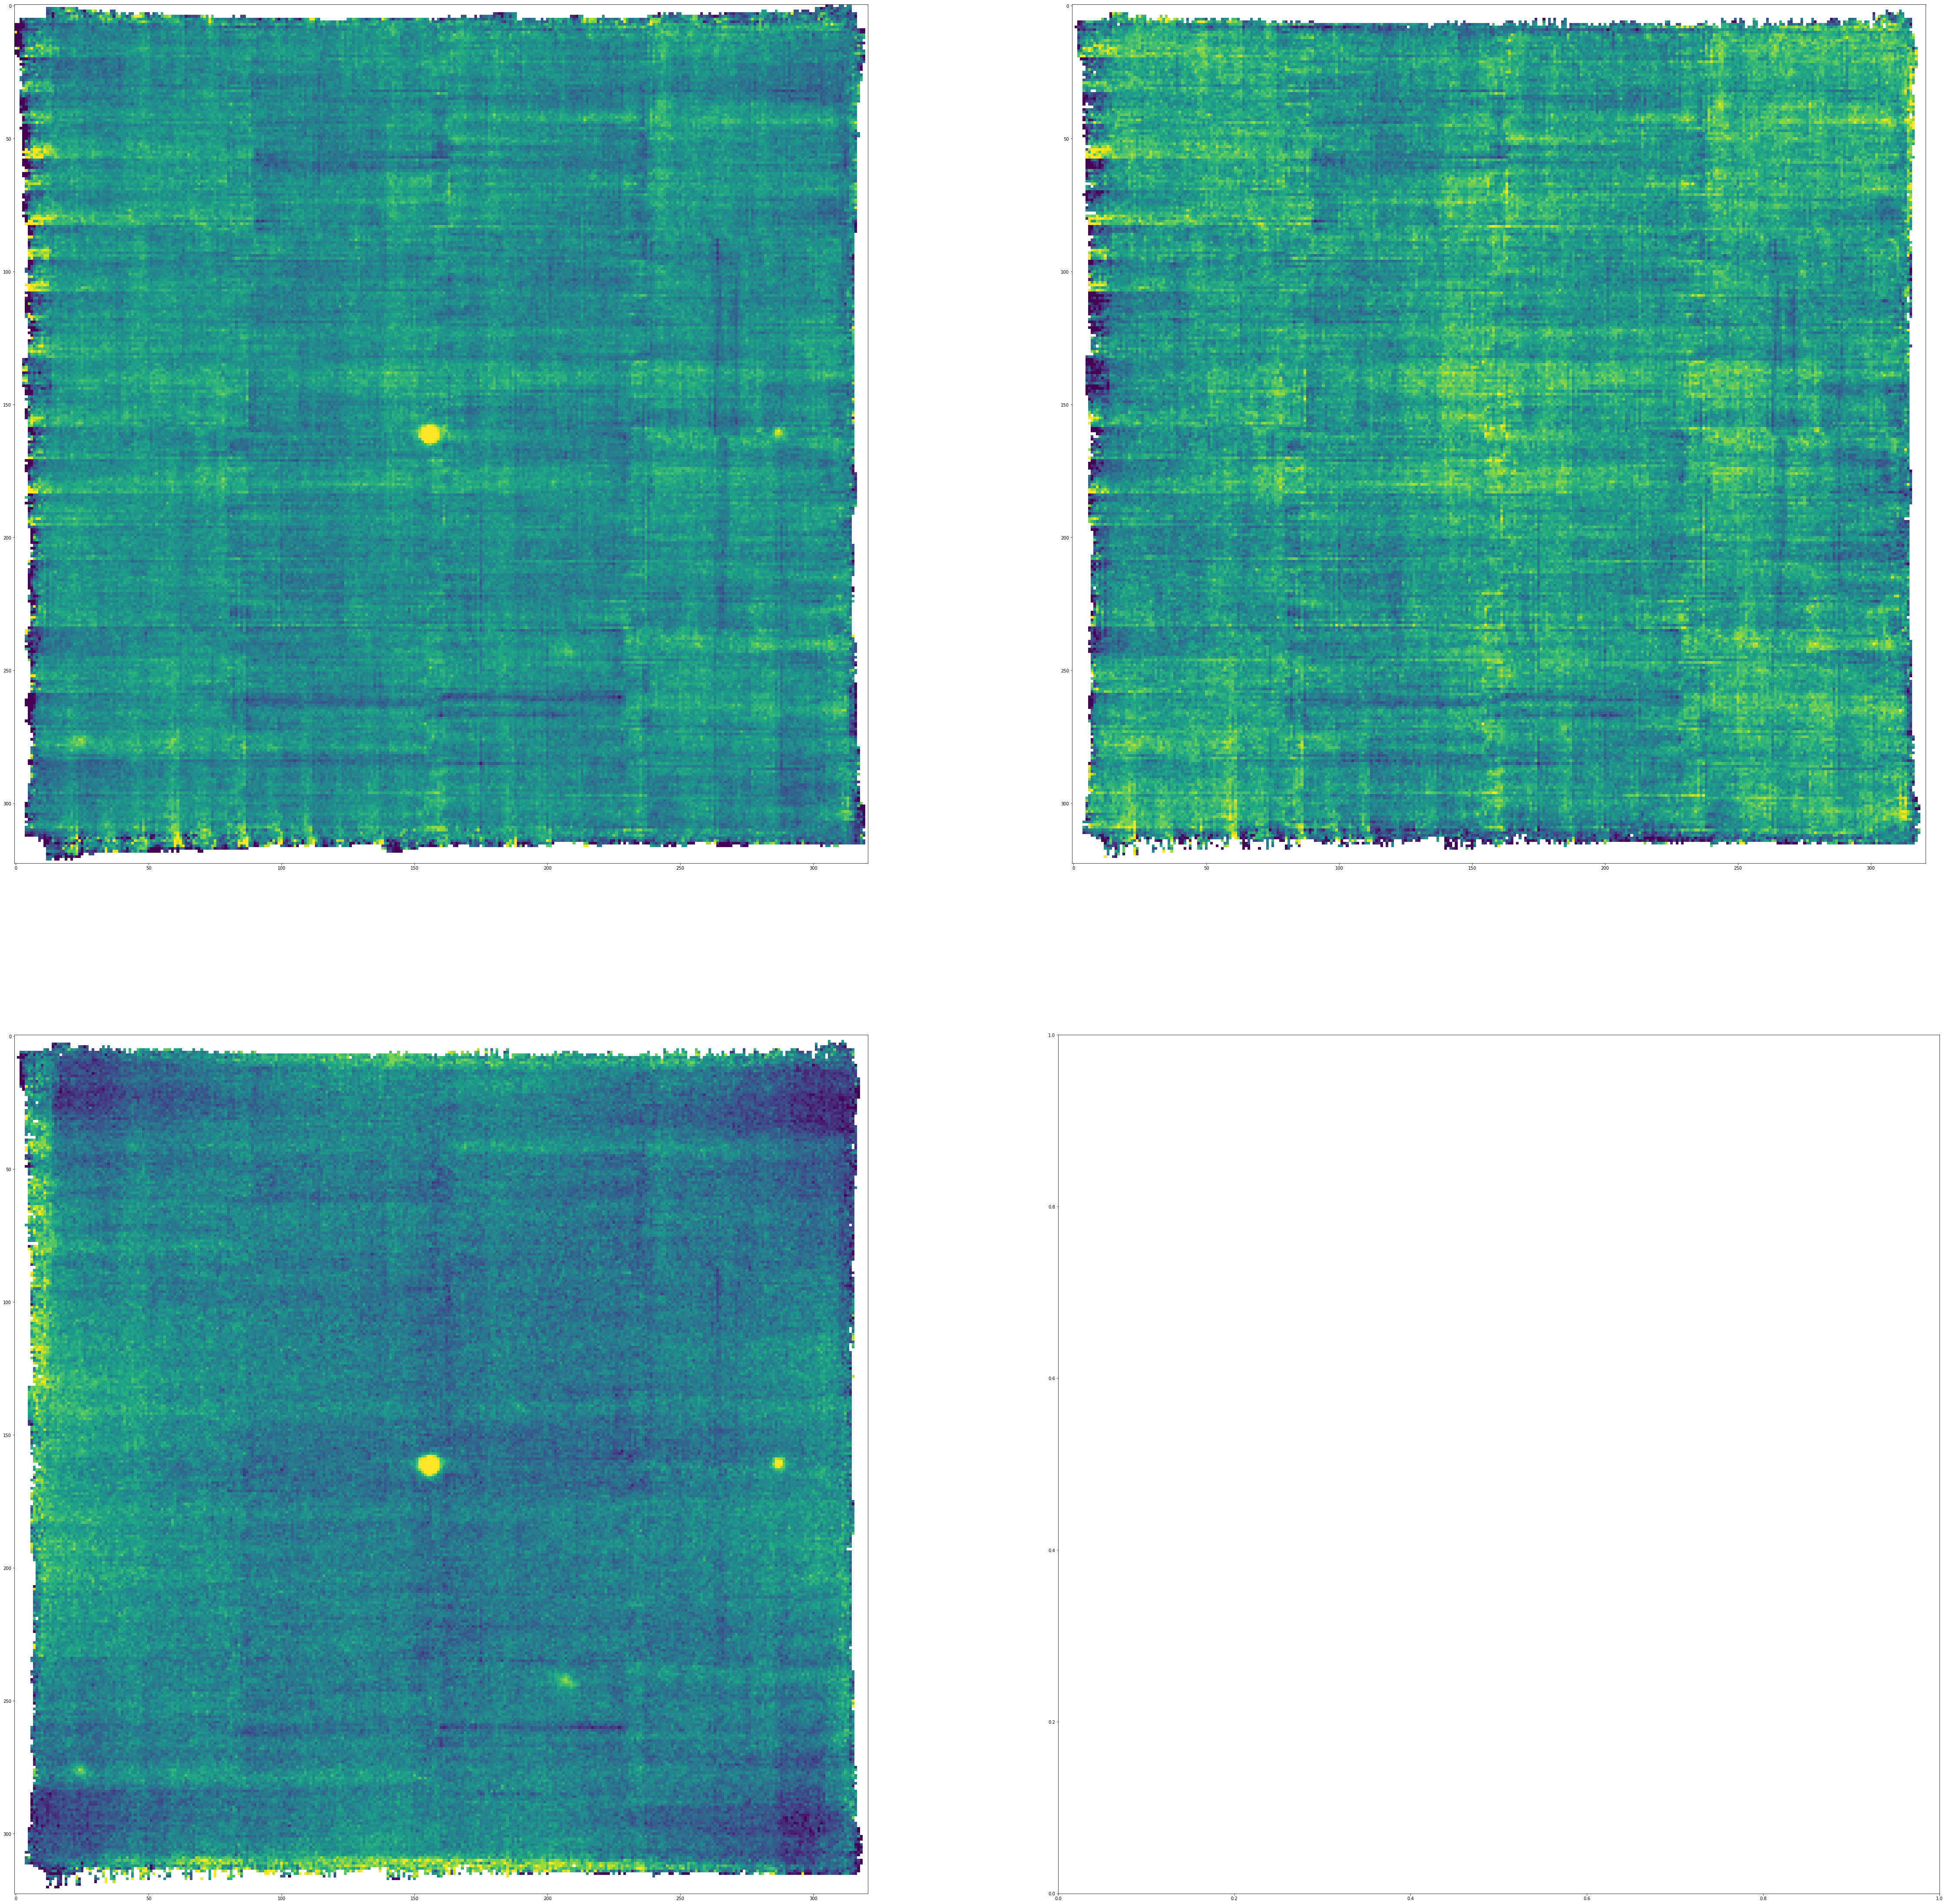

In [223]:
fig,AX=plt.subplots(2,2)
AX=AX.flatten()
imglist=[cube[3769,:,:],patterncube[3769,:,:],cube[3769,:,:]-1.*patterncube[3769,:,:]]

for i in range(3):
    Plotfitsimg(imglist[i],AX[i])
plt.show()
plt.rcParams['figure.figsize'] =[80.,80.]

In [12]:
header=CubeData.Readheader(path='/Users/shiwuzhang/W&S/ASTRO/MUSE/data',
                               name='extra-galactic-field1.fits',ext=1)
header['BUNIT']='10**(-20)*erg/s/cm**2'
os.chdir('/Users/shiwuzhang/W&S/ASTRO/MUSE')
CubeData.Imgreadout(goodimg,header,'img'+'.fits')
# CubeData.Imgreadout(goodimg,header,'BW_good4'+'.fits')
# CubeData.Imgreadout(f_real,header,'img_freal'+'.fits')
# CubeData.Imgreadout(f_imag,header,'img_fimag'+'.fits')
# CubeData.Imgreadout(patterncube,header,'cube_pattern'+'.fits')
# CubeData.Imgreadout(cube_new,header,'cube'+'.fits')
# CubeData.Imgreadout(goodcube,header,'cube_good'+'.fits')

In [422]:
def cat2reg(path,cat_name,reg_name):
    
    os.chdir(path)
    cata=np.genfromtxt(cat_name)
    reg=[]
    for i in cata:
        aper='circle('+str(i[1])+','+str(i[2])+',1")\n'
        reg.append(aper)
    region=open(reg_name,'w')
    region.writelines(reg)
    region.close()
    return None
cat2reg('/Users/shiwuzhang/W&S/ASTRO/MUSE/muse_sex',
       'muse.cat','muse23.reg')